In [1]:
from datetime import datetime

print()
start = datetime.now()
print(f'Start Time : {start}')


Start Time : 2023-05-31 15:07:51.093769


In [9]:
from tab_opt.optimize.mcmc import inv_kernel_vmap, inv_kernel, log_normal, log_multinorm, log_multinorm_sum
from tabascal.jax.coordinates import orbit, GEO_to_XYZ
from tabascal.utils.jax import progress_bar_scan

from jax import random, jit, vmap, jacrev, jacfwd
import jax.numpy as jnp

from jax.flatten_util import ravel_pytree as flatten
from jax.lax import scan

from jax.tree_util import tree_map

from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import h5py

import os

import dask.array as da
import xarray as xr 

from jax.config import config
config.update("jax_enable_x64", True)

plt.rcParams['font.size'] = 16

In [16]:
baseline = 1867
# baseline = 1380
baseline = 0

In [17]:
N_ant = 4
N_sat = 2

sim_dir = "/Users/chrisfinlay/Documents/PhD/tabascal/tabascal/tabascal/examples/"
f_name = f"target_obs_{N_ant:02}A_450T-0440-1338_128I_001F-1.227e+09-1.227e+09_100AST_{N_sat:}SAT_0GRD/"

sim_path = os.path.join(sim_dir, f_name)

ds = xr.open_zarr(sim_path)

In [18]:
bl_uvw = ds.bl_uvw.data.compute()[0,:,:]
mag_uvw = jnp.linalg.norm(bl_uvw, axis=-1)
jnp.argmax(mag_uvw), jnp.argmin(mag_uvw)

(Array(1, dtype=int64), Array(4, dtype=int64))

In [19]:
sampling = 1

N_int_samples = ds.attrs["n_int_samples"]//sampling
N_ant = ds.attrs["n_ant"]
N_bl = ds.attrs["n_bl"]
N_time = ds.attrs["n_time"]
N_time_fine = ds.attrs["n_time_fine"]//sampling
times = ds.coords["time"].data
times_fine = ds.coords["time_fine"].data[::sampling]
bl_uvw = ds.bl_uvw.data.compute()[::sampling, baseline]
# ants_uvw = ds.ants_uvw.data.compute()[::sampling]
# ants_xyz = ds.ants_xyz.data.compute()[::sampling]
vis_ast = ds.vis_ast.data.compute()[::sampling, baseline, 0]
vis_rfi = ds.vis_rfi.data.compute()[::sampling, baseline, 0]
vis_obs = ds.vis_obs.data.compute()[:, baseline, 0]
noise = ds.noise_std.data.compute()
int_time = ds.attrs["int_time"]
freqs = ds.coords["freq"].data
gains_ants = ds.gains_ants.data.compute()[::sampling]
rfi_A_app = ds.rfi_sat_A.data.compute()[:,::sampling]
ang_seps = ds.rfi_sat_ang_sep.data.compute()


from tabascal.jax.interferometry import ants_to_bl
a1 = ds.antenna1.data.compute()
a2 = ds.antenna2.data.compute()
gains_bl = ants_to_bl(gains_ants.reshape(N_time, -1, N_ant, 1).mean(axis=1), a1[baseline], a2[baseline])[:,0]

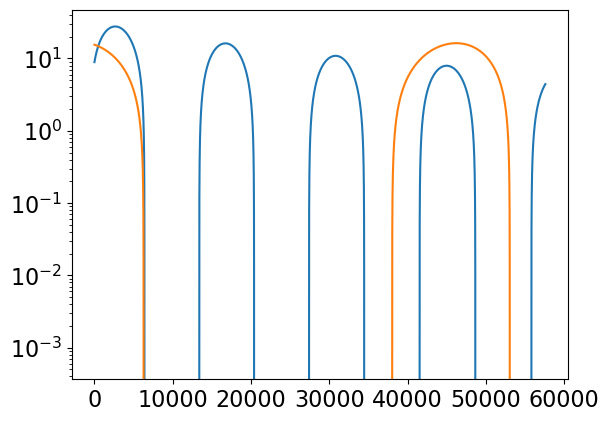

In [20]:
plt.semilogy(rfi_A_app[:,:,0,0].T)

(-1.5, 0.0)

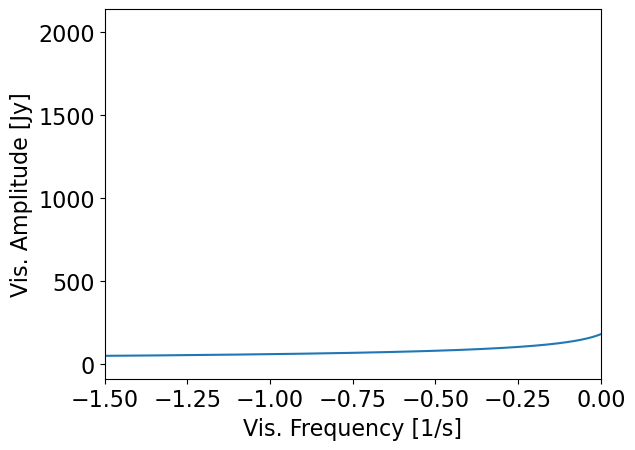

In [21]:
plt.plot(-jnp.fft.fftshift(jnp.fft.fftfreq(len(vis_rfi), jnp.diff(times_fine)[0])), 
         jnp.fft.fftshift(jnp.sqrt(jnp.abs(jnp.fft.fft(vis_rfi)))))
plt.xlabel('Vis. Frequency [1/s]')
plt.ylabel('Vis. Amplitude [Jy]')
plt.xlim(-1.5, 0)

Text(0, 0.5, 'RFI Vis. Real [Jy]')

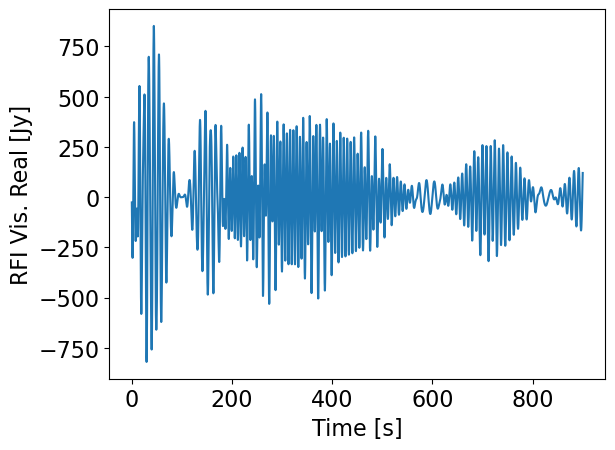

In [22]:
plt.plot(times_fine-times_fine[0], vis_rfi.real)
plt.xlabel('Time [s]')
plt.ylabel('RFI Vis. Real [Jy]')

Text(0, 0.5, 'RFI Vis. Phase [Jy]')

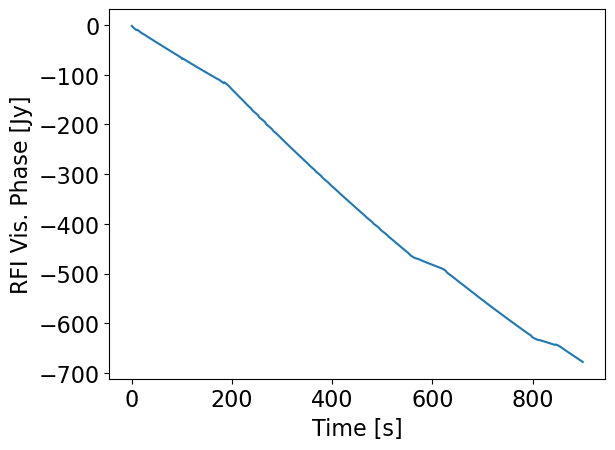

In [23]:
plt.plot(times_fine-times_fine[0], jnp.unwrap(jnp.angle(vis_rfi)))
plt.xlabel('Time [s]')
plt.ylabel('RFI Vis. Phase [Jy]')

In [24]:
print()
print(f'Number of Antennas: {N_ant}')
print()
print(f'Number of Time Steps: {N_time}')


Number of Antennas: 4

Number of Time Steps: 450


In [25]:
@jit
def kernel(x, x_, var, l, noise=1e-3):
    '''
    x: array (n_points, n_dim)
    '''
    x = x[:,None] if x.ndim==1 else x
    x_ = x_[:,None] if x_.ndim==1 else x_
    chi = jnp.linalg.norm(x[None,:,:]-x_[:,None,:], axis=-1) / l
    cov = jnp.abs(var)*jnp.exp(-0.5*chi**2)
    if chi.shape[0]==chi.shape[1]:
        cov += noise*jnp.eye(x.shape[0])
    return cov

@jit
def resampling_kernel(x_old, x_new, var, l, noise=1e-3):
    K_inv = jnp.linalg.inv(kernel(x_old, x_old, var, l, noise))
    K_s = kernel(x_old, x_new, var, l)
    return K_s@K_inv

In [26]:
@jit
def gp_resample(y, x, x_, var, l, noise=1e-3):
    K_inv = jnp.linalg.inv(kernel(x, x, var, l, noise))
    K_s = kernel(x, x_, var, l)
    return K_s@K_inv@y

@jit
def resampled_cov(x, x_, var, l, noise_cov):
    K = kernel(x, x, var, l, 1e-3)
    K_inv = jnp.linalg.inv(K + noise_cov)
    K_s = kernel(x, x_, var, l)
    K_ss = kernel(x_, x_, var, l)
    return K_ss - K_s@K_inv@K_s.T

In [27]:
@jit
def rfi_vis(q, params):
    
    vis_rfi = params['resample_rfi']@(q['rfi_real'] + 1.j*q['rfi_imag'])
    V_rfi = vis_rfi * jnp.conj(params['delay_rotation'])
    
    return V_rfi.reshape(N_time, N_int_samples).mean(axis=1)

@jit
def model(q, params):
    
    V_ast = params['resample_ast']@(q['ast_real'] + 1.j*q['ast_imag'])

    V_rfi = rfi_vis(q, params)

    V_model = V_ast + V_rfi

    return jnp.concatenate([V_model.real.flatten(), V_model.imag.flatten()])

In [28]:
def l_from_uv(uv, l0=7e2, a=6e-4):
    return l0*jnp.exp(-a*uv)

def get_times(gp_l, times):
    
    int_time = times[1] - times[0]
    t_i = times[0] - int_time/2
    t_f = times[-1] + int_time/2
    n_vis_times = jnp.ceil(2. * ((t_f - t_i)/gp_l) + 1).astype(int)
    vis_times = jnp.linspace(t_i, t_f, n_vis_times)
    
    return vis_times

def fringe_phasor(w, freq):
    
    from tabascal.jax.interferometry import c
    phasor = jnp.exp(-2.j*jnp.pi*freq/c*w)
    
    return phasor

def derotated_vis_phase(vis, w, freq):
    
    derotated_vis = vis*fringe_phasor(w, freq)
    phase = jnp.unwrap(jnp.angle(derotated_vis), discont=0.0)
    
    return phase

def derotated_vis(vis, w, freq):
    
    return vis*fringe_phasor(w, freq)

## Astronomical Real and imaginary Parameterization

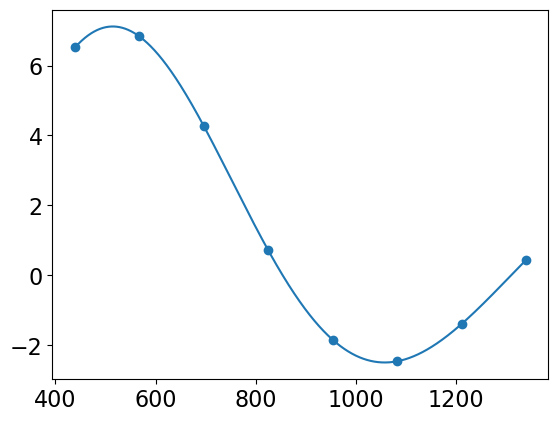

In [29]:
mag_uvw = jnp.linalg.norm(bl_uvw[0], axis=-1)
ast_l = l_from_uv(mag_uvw, l0=5e2)
ast_var = (jnp.abs(vis_ast).max(axis=(0)) + noise)**2

ast_times = get_times(ast_l, times)

resample_ast = resampling_kernel(ast_times, times, ast_var, ast_l)

ast_real = jnp.interp(ast_times, times_fine, vis_ast.real)
ast_imag = jnp.interp(ast_times, times_fine, vis_ast.imag)

plt.plot(times_fine, vis_ast.real)
plt.plot(ast_times, ast_real, 'o', color='tab:blue');

## RFI Real and Imaginary Parameterization

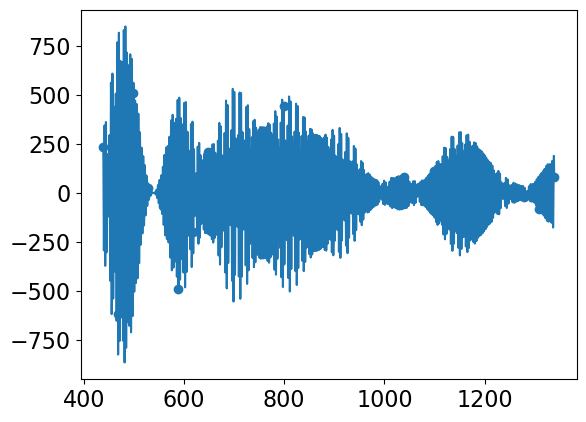

In [30]:
rfi_var, rfi_l = 1.0e6, 60.

rfi_times = get_times(rfi_l, times)

resample_rfi = resampling_kernel(rfi_times, times_fine, rfi_var, rfi_l, noise=1e-2)

derotated_rfi_vis = derotated_vis(vis_rfi, bl_uvw[:,-1], freqs)

rfi_real = jnp.interp(rfi_times, times_fine, derotated_rfi_vis.real)
rfi_imag = jnp.interp(rfi_times, times_fine, derotated_rfi_vis.imag)

plt.plot(times_fine, (vis_rfi*fringe_phasor(bl_uvw[:,-1], freqs)).real)
plt.plot(rfi_times, rfi_real, 'o', color='tab:blue');

In [31]:
# rfi_var, rfi_l = 1.0e6, 15.

# rfi_times = get_times(rfi_I_l, times)

# resample_rfi_I = resampling_kernel(rfi_I_times, times_fine, rfi_I_var, rfi_I_l, noise=1e-2)

# derotated_rfi_vis = derotated_vis(vis_rfi[:,:,0], bl_uvw[:,:,-1], freqs)

# rfi_real = vmap(jnp.interp, in_axes=(None,None,1), out_axes=(1))(rfi_times, times_fine, derotated_rfi_vis.real)
# rfi_imag = vmap(jnp.interp, in_axes=(None,None,1), out_axes=(1))(rfi_times, times_fine, derotated_rfi_vis.imag)

# plt.plot(times_fine, (vis_rfi[:,:10,0]*fringe_phasor(bl_uvw[:,:10,-1], freqs)).real)
# plt.plot(rfi_times, rfi_real[:,:10], '.');

## RFI Amplitude and Phase Parametrization

In [32]:
# rfi_I_var, rfi_I_l = 1.0e6, 15.

# rfi_phase_var, rfi_phase_l = 1.5, 15.

# rfi_I_times = get_times(rfi_I_l, times)
# rfi_phase_times = get_times(rfi_phase_l, times)

# resample_rfi_I = resampling_kernel(rfi_I_times, times_fine, rfi_I_var, rfi_I_l, noise=1e-2)
# resample_rfi_phase = resampling_kernel(rfi_phase_times, times_fine, rfi_phase_var, rfi_phase_l, noise=1e-2)

# derotated_rfi_phase = vmap(derotated_vis_phase, in_axes=(1,1,None), out_axes=(1))(vis_rfi[:,:,0], bl_uvw[:,:,-1], freqs)

# rfi_I = vmap(jnp.interp, in_axes=(None,None,1), out_axes=(1))(rfi_phase_times, times_fine, jnp.abs(vis_rfi[:,:,0]))
# rfi_phase = vmap(jnp.interp, in_axes=(None,None,1), out_axes=(1))(rfi_phase_times, times_fine, derotated_rfi_phase)

# plt.plot(times_fine, derotated_rfi_phase[:,:10]);
# # plt.plot(rfi_phase_times, rfi_phase[:,:10], '.');
# plt.plot(times_fine, resample_rfi_phase@rfi_phase[:,:10]);

# plt.figure()
# plt.plot(times_fine, jnp.abs(vis_rfi[:,:10,0]));
# plt.plot(rfi_phase_times, rfi_I[:,:10], '.');
# # plt.plot(times_fine, resample_rfi_phase@rfi_I[:,:10]);

In [33]:
true_values = {
    'rfi_real': rfi_real,
    'rfi_imag': rfi_imag,
    'ast_real': ast_real,
    'ast_imag': ast_imag,
}

####################################################################

vis_obs_cal = vis_obs / gains_bl

# Set Constant Parameters
params = {
    'noise': noise,
    'delay_rotation': fringe_phasor(bl_uvw[:,-1], freqs),
    # 'vis_obs': vis_obs_cal,
    'vis_obs': vis_obs,
}

prior_params = {
    'mu_vis_rfi': jnp.zeros(len(rfi_times)),
    'inv_cov_vis_rfi': inv_kernel(rfi_times[:,None], 
                                  rfi_var, 
                                  rfi_l),
    'mu_vis_ast': jnp.zeros(len(ast_times)),
    'inv_cov_vis_ast': inv_kernel(ast_times[:,None], 
                                  ast_var, 
                                  ast_l),
    'resample_ast': resample_ast,
    'resample_rfi': resample_rfi,
               }

params.update(prior_params)

In [34]:
@jit
def nlp(q, params):
    
    lp = log_multinorm(q['ast_real'], params['mu_vis_ast'], params['inv_cov_vis_ast']) + \
         log_multinorm(q['ast_imag'], params['mu_vis_ast'], params['inv_cov_vis_ast']) + \
         log_multinorm(q['rfi_real'], params['mu_vis_rfi'], params['inv_cov_vis_rfi']) + \
         log_multinorm(q['rfi_imag'], params['mu_vis_rfi'], params['inv_cov_vis_rfi'])

    return -1.0*lp

@jit
def nll(q, params):

    V_model = model(q, params)

    V_obs = jnp.concatenate([params['vis_obs'].real,
                             params['vis_obs'].imag])

    return -1. * log_normal(V_obs, V_model, params['noise'])

@jit
def U(q, params):

    nl_like = nll(q, params).sum()
        
    nl_post = nlp(q, params) + nl_like

    return nl_post

delU = jit(jacrev(U, 0))

In [35]:
%timeit -r 3 nlp.lower(true_values, params).compile()

41.5 ms ± 643 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [36]:
@jit
def nl_like(q, params):
    return nll(q, params).sum()

In [37]:
%timeit -r 3 nl_like.lower(true_values, params).compile()

35 ms ± 226 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [38]:
vis = model(true_values, params)

In [39]:
n_log = nll(true_values, params)
n_log= n_log.T[N_time:] + n_log.T[:N_time]
n_log.mean()

Array(156509.42679866, dtype=float64)

In [40]:
%timeit -r 3 U.lower(true_values, params).compile()

71.6 ms ± 177 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [41]:
print()
print(f'Energy per data point @ true: {U(true_values, params)/params["vis_obs"].size}')
print()
print(f'U compiled {U._cache_size()} time(s).')


Energy per data point @ true: 156862.36659003032

U compiled 1 time(s).


In [42]:
from jax.scipy.linalg import block_diag

In [43]:
###############################################################

F_prior = {
    'rfi_real': params['inv_cov_vis_rfi'],
    'rfi_imag': params['inv_cov_vis_rfi'],
    'ast_real': params['inv_cov_vis_ast'],
    'ast_imag': params['inv_cov_vis_ast'],
          }

def fisher_block(q, params, F_prior):
    
    J = jacrev(model)(q, params)
    F_block = tree_map(lambda J, F_prior: J.T@J/params['noise']**2 + F_prior, J, F_prior)
    
    return F_block

def fisher(q, params, F_prior):
    J = flatten(jacrev(model)(q, params))[0]
    F = J.T@J/params['noise']**2 + block_diag(F_prior['ast_imag'], F_prior['ast_real'], 
                                              F_prior['rfi_imag'], F_prior['rfi_real'])
    
    return F
    

################
def block_std(F_block):

    std = tree_map(lambda F: jnp.sqrt(jnp.diag(jnp.linalg.inv(F))), F_block)

    return std

#############################################################

# q_dev = {
#     'ast_real': noise*random.normal(random.PRNGKey(10)),
#     'ast_imag': noise*random.normal(random.PRNGKey(11)),
#     'rfi_real': noise*random.normal(random.PRNGKey(12)),
#     'rfi_imag': noise*random.normal(random.PRNGKey(13)),
#         }

# qi = tree_map(lambda x, y: x + y, true_values, q_dev)

qi = tree_map(lambda x: jnp.mean(x)*jnp.ones(len(x)), true_values)

qi = {
    'rfi_real': jnp.zeros(len(rfi_times)),
    'rfi_imag': jnp.zeros(len(rfi_times)),
    'ast_real': jnp.zeros(len(ast_times)),
    'ast_imag': jnp.zeros(len(ast_times)),
}

vis_rfi_est = jnp.interp(rfi_times, times, params['vis_obs']*jnp.interp(times, times_fine, fringe_phasor(bl_uvw[:,-1], freqs)))

qi = {
    'rfi_real': vis_rfi_est.real,
    'rfi_imag': vis_rfi_est.imag,
    'ast_real': jnp.mean(params['vis_obs'].real)*jnp.ones(len(ast_times)),
    'ast_imag': jnp.mean(params['vis_obs'].imag)*jnp.ones(len(ast_times)),
}

#########################################

print()
print(f'Number of data points: {2*params["vis_obs"].size}')
print()
print(f'Number of parameters: {len(flatten(qi)[0])}')
print()
print(f'Energy per data point @ qi: {U(qi, params)/params["vis_obs"].size}')
print()
# print(f'U compiled {U._cache_size()} time(s).')
# print()


Number of data points: 900

Number of parameters: 78

Energy per data point @ qi: 91359.6491084117



In [44]:
# Block Fisher

@jit
def grad_precond(qi, params, F_prior):
    F = fisher_block(qi, params, F_prior)
    F_inv = tree_map(jnp.linalg.inv, F)
    return F_inv

@jit
def nat_grad_step(q, alpha, F_inv):
    update = lambda F_inv, D: alpha*F_inv@D
    D = delU(q, params)
    return tree_map(update, F_inv, D)

In [182]:
# # Full Fisher

# @jit
# def grad_precond(qi, params, F_prior):
#     F = fisher(qi, params, F_prior)
#     F_inv = jnp.linalg.inv(F)
#     return F_inv

# @jit
# def nat_grad_step(q, alpha, F_inv):
    
#     D, unflatten = flatten(delU(q, params))
#     return unflatten(alpha*F_inv@D)

In [45]:
def nat_grad(qi, alpha, Niter=1000, N_iter_2=1000, tol=1e-6):
    
    F_inv = grad_precond(qi, params, F_prior)
    
    U_i = U(qi, params)/vis_obs.size
    pbar = tqdm(range(0, Niter))
    for i in pbar:
        step = alpha*0.99**(i/10000)
        def update(qi, i):
            return tree_map(lambda x, y: x-y, qi, nat_grad_step(qi, step, F_inv)), i
        qi = scan(update, qi, jnp.arange(N_iter_2))[0]
        
        F_inv = grad_precond(qi, params, F_prior)
        
        U_f = U(qi, params)/vis_obs.size
        pbar.set_description(f'NL Posterior = {round(float(U_f), 3)}, alpha = {step:.1E}')
        if U_i-U_f < tol:
            if U_f > U_i and U_f > 2.:
                print('Failed to converge!')
                return None
            return qi
        U_i = U_f
    return qi

MAP = nat_grad(qi, 1e-2, 10000, tol=1e-5)
# MAP = nat_grad(MAP, 1e-3, 10000, tol=1e-5)

NL Posterior = 77283.611, alpha = 1.0E-02:   0%|                                             | 2/10000 [00:23<32:12:34, 11.60s/it]

Failed to converge!


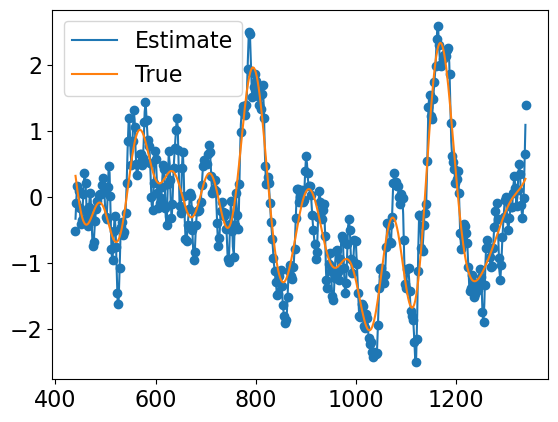

In [184]:
plt.plot(times, resample_ast@MAP['ast_real'], color='tab:blue', label='Estimate')
plt.plot(ast_times, MAP['ast_real'], 'o', color='tab:blue')
plt.plot(times, (gains_bl*vis_ast.reshape(N_time,-1).mean(axis=1)).real, color='tab:orange', label='True')
plt.legend()

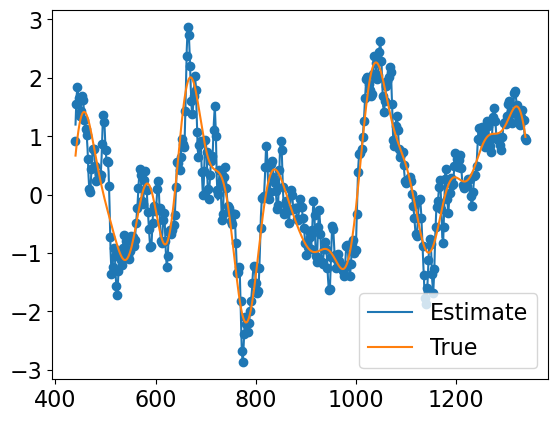

In [185]:
plt.plot(times, resample_ast@MAP['ast_imag'], color='tab:blue', label='Estimate')
plt.plot(ast_times, MAP['ast_imag'], 'o', color='tab:blue')
plt.plot(times, (gains_bl*vis_ast.reshape(N_time,-1).mean(axis=1)).imag, color='tab:orange', label='True')
plt.legend()

In [ ]:
# bl = 37

# norm = jnp.sqrt(jnp.outer(jnp.diag(F_inv['v_real'][bl]), jnp.diag(F_inv['v_real'][bl])))
# norm = jnp.ones(F_inv['v_real'][bl].shape)
# plt.imshow(F_inv['v_real'][bl]/norm)
# plt.colorbar()

# plt.figure()
# norm = jnp.sqrt(jnp.outer(jnp.diag(F_prior_inv['v_real'][bl]), jnp.diag(F_prior_inv['v_real'][bl])))
# norm = jnp.ones(F_inv['v_real'][bl].shape)
# plt.imshow(F_prior_inv['v_real'][bl]/norm)
# plt.colorbar()

In [ ]:
# F_prior_inv = tree_map(jnp.linalg.inv, F_prior)

In [475]:
def saveParams(file_path, q, F_inv):
    with h5py.File(file_path, 'w') as fp:
        fp['times_fine'] = times
        
        for i in range(len(q['v_real'])):
            fp[f'vis/{i}'] = q['v_real'][i] + 1.j*q['v_imag'][i]
            fp[f'vis_cov/{i}'] = F_inv['v_real'][i]
            fp[f'vis_times/{i}'] = vis_times[i]
        fp['vis_var'] = vis_var
        fp['vis_l'] = vis_l
        
        V_real = flatten(tree_map(pad_vis, q['v_real']))[0].reshape(N_bl, N_vis_time)
        V_imag = flatten(tree_map(pad_vis, q['v_imag']))[0].reshape(N_bl, N_vis_time)
        fp['vis_fine'] = vmap(jnp.dot)(params['resample_vis'], (V_real + 1.j*V_imag))
        
        G_amp = flatten(q['g_amp'])[0].reshape(N_ant, N_g_time)
        G_phase = flatten(q['g_phase'])[0].reshape(N_ant-1, N_g_time)
        G_phase = jnp.concatenate([G_phase, jnp.zeros((1, N_g_time))], axis=0)
        G = G_amp*jnp.exp(1.j*G_phase)
        fp['gains'] = G

        G_amp = (params['resample_g_amp']@G_amp.T)
        G_phase = (params['resample_g_phase']@G_phase.T)
        G = G_amp*jnp.exp(1.j*G_phase)
        fp['gains_fine'] = G
        
        # rfi_amp = flatten(q['rfi_amp'])[0].reshape(N_ant, N_rfi_time).T
        # fp['rfi_amp'] = rfi_amp
        # fp['rfi_amp_fine'] = params['resample_rfi']@rfi_amp
        # fp['rfi_orbit'] = q['rfi_orbit']
        
        fp['g_amp_cov'] = flatten(F_inv['g_amp'])[0].reshape(N_ant,N_g_time,N_g_time)
        
        fp['g_phase_cov'] = flatten(F_inv['g_phase'])[0].reshape(N_ant-1,N_g_time,N_g_time)
        
        # fp['rfi_amp_cov'] = flatten(F_inv['rfi_amp'])[0].reshape(N_ant,N_rfi_time,N_rfi_time)
        # fp['rfi_orbit_cov'] = F_inv['rfi_orbit']

In [476]:
saveParams(f'Params_{N_ant}A_StationaryRFI3.h5', MAP, F_inv)

In [477]:
# saveParams(f'Params_{N_ant}A_Reduced.h5', true_values, F_inv)

In [39]:
print()
print('Estimating Posterior Errors')
print('---------------------------')

# std = block_std(F)

with h5py.File(f'Params_{N_ant}A_StationaryRFI3.h5', 'r') as fp:
    v_pred = fp['vis_fine'][()].T
    noise_cov = {i: fp['vis_cov'][f'{i}'][()] for i in range(N_bl)}
    vis_times = {i: fp['vis_times'][f'{i}'][()] for i in range(N_bl)}
    vis_var_d = {i: fp['vis_var'][i] for i in range(N_bl)}
    vis_l_d = {i: fp['vis_l'][i] for i in range(N_bl)}
v_pred = jnp.concatenate([v_pred.real.flatten(), v_pred.imag.flatten()])
cov_fine = tree_map(resampled_cov, vis_times, {i: times for i in range(N_bl)}, vis_var_d, vis_l_d, noise_cov)
v_std = vmap(lambda x: jnp.sqrt(jnp.diag(x)))(flatten(cov_fine)[0].reshape(N_bl,N_time,N_time))
v_std = jnp.sqrt(jnp.concatenate([v_std.flatten(), v_std.flatten()]))
v_true = vis_ast.reshape(N_time, N_int_samples, -1).mean(axis=1)
v_true = jnp.concatenate([v_true.real.flatten(), v_true.imag.flatten()])
res = v_pred - v_true

bias = res/v_std

print()
print(f'RMSE : {jnp.sqrt(jnp.mean(res**2))}')
print()
print(f'STD : {v_std.mean()}')
print()
print('Normalized')
print('-----------')
print(f'Mean : {bias.mean()}')
print(f'STD : {bias.std()}')


Estimating Posterior Errors
---------------------------

RMSE : 0.9215109690816788

STD : 0.32629414668771894

Normalized
-----------
Mean : -0.11958846471561328
STD : 2.9177489798623584


In [479]:
b = jnp.abs(bias)
100*len(b[b<1])/len(b)

88.35215053763442

In [480]:
print()
print(f'End Time : {datetime.now()}')
print()
print(f'Time Taken: {datetime.now()-start}')


End Time : 2023-03-17 18:08:14.885985

Time Taken: 3:37:52.249540


Text(0, 0.5, 'Visibility Real [Jy]')

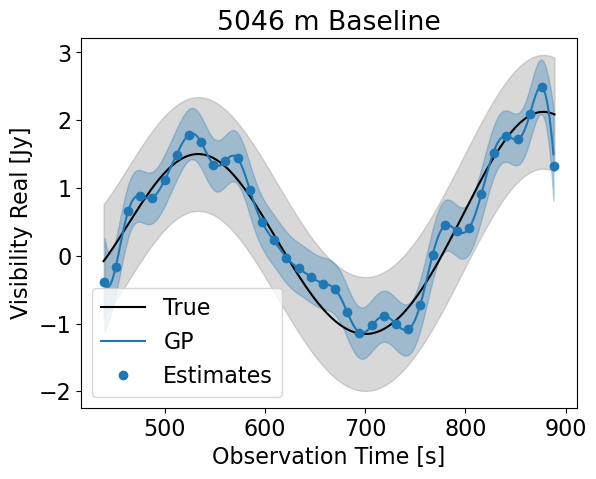

In [481]:
bl = int(jnp.argmin(flatten(vis_l)[0]))
n_std = 2

with h5py.File(f'Params_{N_ant}A_StationaryRFI3.h5', 'r') as fp:
    vis = {i: fp[f'vis'][f'{i}'][()] for i in range(N_bl)}
    v_pred = fp['vis_fine'][()].T
    noise_cov = {i: fp['vis_cov'][f'{i}'][()] for i in range(N_bl)}
cov_fine = tree_map(resampled_cov, vis_times, {i: times for i in range(N_bl)}, vis_var_d, vis_l_d, noise_cov)
v_std = vmap(lambda x: jnp.sqrt(jnp.diag(x)))(flatten(cov_fine)[0].reshape(N_bl,N_time,N_time)).T

est = vis[bl].real
mean = v_pred[:,bl].real
std = v_std[:,bl]
true = vis_ast[:,bl,0].real
noise = noise/jnp.sqrt(2.)

plt.plot(times_fine, true, color='k', label='True')
plt.fill_between(times_fine, true-n_std*noise, true+n_std*noise, 
                 color='tab:grey', alpha=0.3, 
#                  label=f'{int(n_std)}'+r'$\sigma$'
                )
plt.plot(times, mean, color='tab:blue', label='GP')
plt.fill_between(times, mean-n_std*std, mean+n_std*std, 
                 color='tab:blue', alpha=0.3, 
#                  label=f'{int(n_std)}'+r'$\sigma$'
                )
plt.plot(vis_times[bl], est, 'o', color='tab:blue', label='Estimates')

plt.legend()
plt.title(f'{round(mag_uvw[bl])} m Baseline')
plt.xlabel('Observation Time [s]')
plt.ylabel('Visibility Real [Jy]')

Text(0, 0.5, 'Visibility Real [Jy]')

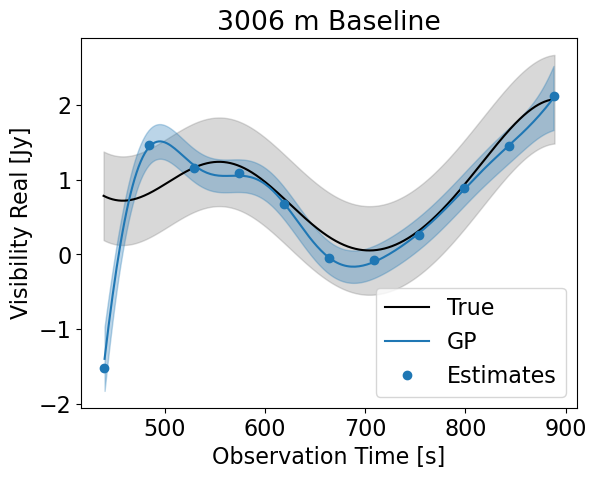

In [482]:
bl = int(jnp.argmin((mag_uvw-3000)**2))
n_std = 2

with h5py.File(f'Params_{N_ant}A_StationaryRFI3.h5', 'r') as fp:
    vis = {i: fp[f'vis'][f'{i}'][()] for i in range(N_bl)}
    v_pred = fp['vis_fine'][()].T
    noise_cov = {i: fp['vis_cov'][f'{i}'][()] for i in range(N_bl)}
cov_fine = tree_map(resampled_cov, vis_times, {i: times for i in range(N_bl)}, vis_var_d, vis_l_d, noise_cov)
v_std = vmap(lambda x: jnp.sqrt(jnp.diag(x)))(flatten(cov_fine)[0].reshape(N_bl,N_time,N_time)).T

est = vis[bl].real
mean = v_pred[:,bl].real
std = v_std[:,bl]
true = vis_ast[:,bl,0].real
noise = noise/jnp.sqrt(2.)

plt.plot(times_fine, true, color='k', label='True')
plt.fill_between(times_fine, true-n_std*noise, true+n_std*noise, 
                 color='tab:grey', alpha=0.3, 
#                  label=f'{int(n_std)}'+r'$\sigma$'
                )
plt.plot(times, mean, color='tab:blue', label='GP')
plt.fill_between(times, mean-n_std*std, mean+n_std*std, 
                 color='tab:blue', alpha=0.3, 
#                  label=f'{int(n_std)}'+r'$\sigma$'
                )
plt.plot(vis_times[bl], est, 'o', color='tab:blue', label='Estimates')

plt.legend()
plt.title(f'{round(mag_uvw[bl])} m Baseline')
plt.xlabel('Observation Time [s]')
plt.ylabel('Visibility Real [Jy]')

Text(0, 0.5, 'Visibility Real [Jy]')

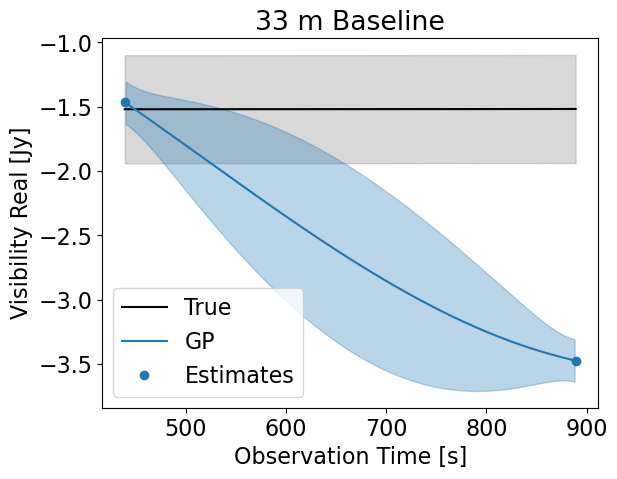

In [483]:
bl = int(jnp.argmax(flatten(vis_l)[0]))
n_std = 2

with h5py.File(f'Params_{N_ant}A_StationaryRFI3.h5', 'r') as fp:
    vis = {i: fp[f'vis'][f'{i}'][()] for i in range(N_bl)}
    v_pred = fp['vis_fine'][()].T
    noise_cov = {i: fp['vis_cov'][f'{i}'][()] for i in range(N_bl)}
cov_fine = tree_map(resampled_cov, vis_times, {i: times for i in range(N_bl)}, vis_var_d, vis_l_d, noise_cov)
v_std = vmap(lambda x: jnp.sqrt(jnp.diag(x)))(flatten(cov_fine)[0].reshape(N_bl,N_time,N_time)).T

est = vis[bl].real
mean = v_pred[:,bl].real
std = v_std[:,bl]
true = vis_ast[:,bl,0].real
noise = noise/jnp.sqrt(2.)

plt.plot(times_fine, true, color='k', label='True')
plt.fill_between(times_fine, true-n_std*noise, true+n_std*noise, 
                 color='tab:grey', alpha=0.3, 
#                  label=f'{int(n_std)}'+r'$\sigma$'
                )
plt.plot(times, mean, color='tab:blue', label='GP')
plt.fill_between(times, mean-n_std*std, mean+n_std*std, 
                 color='tab:blue', alpha=0.3, 
#                  label=f'{int(n_std)}'+r'$\sigma$'
                )
plt.plot(vis_times[bl], est, 'o', color='tab:blue', label='Estimates')

plt.legend()
plt.title(f'{round(mag_uvw[bl])} m Baseline')
plt.xlabel('Observation Time [s]')
plt.ylabel('Visibility Real [Jy]')

In [18]:
@jit
def vis_prior(q):
    V_real = flatten(tree_map(pad_vis, q['v_real']))[0].reshape(N_bl, N_vis_time)
#     V_imag = flatten(tree_map(pad_vis, q['v_imag']))[0].reshape(N_bl, N_vis_time)
    return log_multinorm_sum(V_real, jnp.zeros(N_bl), inv_cov_vis)

In [19]:
@jit
def vis_prior2(q):
    V_real = flatten(q['v_real'])[0]
#     V_imag = flatten(tree_map(pad_vis, q['v_imag']))[0].reshape(N_bl, N_vis_time)
    return log_normal(V_real, jnp.zeros(len(V_real)), sigma).sum()

In [20]:
%timeit -r 7 vis_prior.lower(true_values).compile()

7.41 s ± 342 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%timeit -r 7 vis_prior2.lower(true_values).compile()

417 ms ± 943 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
vis_prior(true_values)

Array(-139.85498607, dtype=float64)

In [23]:
vis_prior2(true_values)

Array(-178.49932835, dtype=float64)

In [24]:
log_multinorm_sum_dict(true_values['v_real'], params['mu_vis'], params['inv_cov_vis'])

NameError: name 'log_multinorm_sum_dict' is not defined

In [13]:
@jit
def log_multinorm_dict(x, mu, inv_cov):
    return tree_multimap(log_multinorm, x, mu, inv_cov)

In [14]:
%timeit -r 7 log_multinorm_dict.lower(true_values['v_real'], params['mu_vis'], params['inv_cov_vis']).compile()

9.46 s ± 597 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%timeit -r 7 log_multinorm_sum_dict.lower(true_values['v_real'], params['mu_vis'], params['inv_cov_vis']).compile()

NameError: name 'log_multinorm_sum_dict' is not defined

In [ ]:
%timeit -r 7 log_multinorm_sum_array.lower(flatten(true_values['g_amp'])[0].reshape(N_ant, N_g_time), params['mu_G_amp'], params['inv_cov_G_amp']).compile()

In [4]:
# class tabascal:
#     def __init__(self, n_ant: int, times: jnp.ndarray, times_fine: jnp.ndarray, freqs: jnp.ndarray, 
#                  qi: dict, true_values: dict, n_int_samples: int, n_rfi_time: int, n_g_time: int, 
#                  n_vis_time: int, scalings: dict, inv_scalings: dict, n_bl: int, noise: float, 
#                  vis_obs: jnp.ndarray, ants_xyz: jnp.ndarray, phase_corrections: jnp.ndarray, 
#                  resamplings: dict, antenna1: jnp.ndarray, antenna2: jnp.ndarray
#                 ):
        
#         self.n_ant = n_ant
#         self.n_time = len(times)
#         self.n_int_samples = n_int_samples
#         self.n_rfi_time = n_rfi_time
#         self.n_g_time = n_g_time
#         self.n_vis_time = n_vis_time
#         self.qi = qi
#         self.q = qi
#         self.times = times
#         self.freqs = freqs
#         self.scalings = scalings
#         self.inv_scalings = inv_scalings
#         self.n_bl = n_bl
#         self.times = times
#         self.times_fine = times_fine
#         self.noise = noise
#         self.ants_xyz = ants_xyz
#         self.phase_corrections = phase_corrections
#         self.vis_obs = vis_obs
#         self.resamplings = resamplings
#         self.true_values = true_values#self.scale_parameters(true_values, scalings)
#         self.antenna1 = antenna1
#         self.antenna2 = antenna2
#         self.baselines = jnp.arange(n_bl)
    
#     @jit
#     def rfi_closures(self, q, ants):

#         rfi_amp = flatten(q['rfi_amp'])[0].reshape(self.n_ant,
#                                                         self.n_rfi_time)[ants]
#         rfi_amp = (self.resamplings['resample_rfi']@rfi_amp.T).T

#         rfi_xyz = orbit(self.times_fine, *q['rfi_orbit'])
#         distances = jnp.linalg.norm(self.ants_xyz[:,ants]-rfi_xyz[:,None,:], axis=2)
#         c_distances = (distances-self.phase_corrections[:,ants])[...,None]

#         return rfi_amp, c_distances
        
#     @jit
#     def rfi_vis(self, app_amplitude, c_distances, freqs):
#         '''
#         Calculate visibilities from distances to rfi sources.

#         Parameters:
#         -----------
#         app_amplitude: jnp.array (n_time, 2, n_freq, n_src)
#             Apparent amplitude at the antennas.
#         c_distances: jnp.array (n_time, 2, n_src)
#             The phase corrected distances between the rfi sources and the antennas.
#         freqs: jnp.array (n_freq,)
#             Frequencies.

#         Returns:
#         --------
#         vis: jnp.array (n_time, 1, n_freq)
#             The visibilities.
#         '''
#         n_time, n_ant, n_freq, n_src = app_amplitude.shape
#         c = 2.99792458e8

#         # Create array of shape (n_time, n_bl, n_freq, n_src) and then sum over n_src

#         minus_two_pi_over_lamda = (-2.0*jnp.pi*freqs/c).reshape(1,1,n_freq,1)

#         c_distances = c_distances.reshape(n_time,n_ant,1,n_src)

#         phase = minus_two_pi_over_lamda*(c_distances[:,0]-c_distances[:,1])
#         intensities_app = app_amplitude[:,0]*app_amplitude[:,1]

#         vis = jnp.sum(intensities_app*jnp.exp(-1.j*phase), axis=-1)

#         return vis

#     @jit
#     def baseline_gains(self, q, ants):

#         G_amp = flatten(q['g_amp'])[0].reshape(self.n_ant, self.n_g_time)[ants]
#         G_phase = flatten(q['g_phase'])[0].reshape(self.n_ant-1, self.n_g_time)
#         G_phase = jnp.concatenate([G_phase, jnp.zeros((1, N_g_time))], axis=0)[ants]

#         G_amp = (self.resamplings['resample_g_amp']@G_amp.T).T
#         G_phase = (self.resamplings['resample_g_phase']@G_phase.T).T

#         G = G_amp*jnp.exp(1.j*G_phase)

#         return G[0]*jnp.conjugate(G[1])

#     @jit
#     def model(self, ant1, ant2, bl):

#         q = self.scale_parameters(self.q, self.inv_scalings)

#         ants = jnp.array([ant1, ant2])

#         V_real = flatten(q['v_real'])[0].reshape(self.n_bl, self.n_vis_time)[bl]
#         V_imag = flatten(q['v_imag'])[0].reshape(self.n_bl, self.n_vis_time)[bl]
#         V_ast = V_real + 1.j*V_imag

#         V_ast = self.resamplings['resample_vis'][bl]@V_ast

#     #     Calculate the visibility contribution from the RFI
#         rfi_amp, c_distances = self.rfi_closures(q, ants)
#         V_rfi = self.rfi_vis(rfi_amp.T[:,:,None,None], c_distances, self.freqs)[...,0]
#         V_rfi = V_rfi.reshape(self.n_time, self.n_int_samples).mean(axis=1)

#         G_bl = self.baseline_gains(q, ants)

#         model_vis = (G_bl*(V_ast+V_rfi))

#         return jnp.concatenate([model_vis.real.flatten(), model_vis.imag.flatten()])

#     @jit
#     def scale_parameters(self, q, scalings):
#         q['g_amp'] = tree_map(lambda x: scalings['g_amp']*x, q['g_amp'])
#         q['g_phase'] = tree_map(lambda x: scalings['g_phase']*x, q['g_phase'])
#         q['rfi_orbit'] = scalings['rfi_orbit']@q['rfi_orbit']
#         return q

    
#     @jit
#     def nll(self, ant1, ant2, bl):

#         V_model = self.model(ant1, ant2, bl)

#         V_obs = jnp.concatenate([self.vis_obs[:,bl].real,
#                                  self.vis_obs[:,bl].imag])

#         return -1. * log_normal(V_obs, V_model, self.noise/jnp.sqrt(2))
    
    
#     @jit
#     def U(self):

#         nl_like = vmap(self.nll, in_axes=(0,0,0))(self.antenna1, self.antenna2, self.baselines).sum()
#         return nl_like
# #         nl_post = nlp(q, params) + nl_like

# #         return nl_post
    
#     def _tree_flatten(self):
#         children = (
# #                     self.qi, 
# #                     self.q,
#                    )  # arrays / dynamic values
#         aux_data = {'qi': self.qi,
#                     'true_values': self.true_values,
#                     'times': self.times,
#                     'times_fine': self.times_fine,
#                     'freqs': self.freqs,
#                     'n_ant': self.n_ant,
#                     'n_int_samples': self.n_int_samples,
#                     'n_rfi_time': self.n_rfi_time,
#                     'n_g_time': self.n_g_time,
#                     'n_vis_time': self.n_vis_time,
#                     'n_bl': self.n_bl,
#                     'scalings': self.scalings,
#                     'inv_scalings': self.scalings,
#                     'noise': self.noise,
#                     'vis_obs': self.vis_obs,
#                     'ants_xyz': self.ants_xyz,
#                     'phase_corrections': self.phase_corrections,
#                     'resamplings': self.resamplings,
#                     'antenna1': self.antenna1,
#                     'antenna2': self.antenna2,
# #                     'baselines': self.baselines
# #                     'n_time': self.n_time,
# #                     'n_rfi_time': self.n_rfi_time,
# #                     'true_values': self.true_values,
#                    }  # static values
#         return (children, aux_data)

#     @classmethod
#     def _tree_unflatten(cls, aux_data, children):
#         return cls(*children, **aux_data)

# from jax import tree_util
# tree_util.register_pytree_node(tabascal,
#                                tabascal._tree_flatten,
#                                tabascal._tree_unflatten)

In [5]:
# scalings = {'g_amp': jnp.array([100.]),
#             'g_phase': jnp.rad2deg(1.),
#             'rfi_orbit': jnp.diag(jnp.array([1e-2, 3600e0, 3600e1, 3600e1]))}

# inv_scalings = tree_map(lambda x: jnp.linalg.inv(x) if x.ndim==2 else 1./x, scalings)

# Nt_fine = len(tar.times_fine)
# #####
# Nt_g = N_int_samples*45
# g_idx = jnp.array(list(np.arange(0, Nt_fine, Nt_g)) + \
#                 [Nt_fine-1,])
# times_g = tar.times_fine[g_idx]
# N_g_time = len(times_g)
# G = tar.gains_ants[g_idx,:,0].T
# #####
# Nt_rfi = 2**5
# rfi_idx = jnp.array(list(np.arange(0, Nt_fine, Nt_rfi)) + \
#                 [Nt_fine-1,])
# times_rfi = tar.times_fine[rfi_idx]
# N_rfi_time = len(times_rfi)
# rfi_A = tar.rfi_A_app[rfi_idx,:,0].T
# ######
# Nt_vis = 150
# vis_idx = jnp.array(list(np.arange(0, Nt_fine, Nt_vis)) + \
#                 [Nt_fine-1,])
# times_vis = tar.times_fine[vis_idx]
# N_vis_time = len(times_vis)
# vis_ast = tar.vis_ast[vis_idx,:,0].T
# ######
# true_values = {'g_amp': {i: x for i, x in enumerate(jnp.abs(G))},
#                'g_phase': {i: x for i, x in enumerate(jnp.angle(G[:-1]))},
#                'rfi_amp': {i: x for i, x in enumerate(rfi_A)},
#                'rfi_orbit': tar.rfi_orbit,
#                'v_real': {i: x for i, x in enumerate(vis_ast.real)},
#                'v_imag': {i: x for i, x in enumerate(vis_ast.imag)}
#                }

# def l_from_uv(uv, l0=7e2, a=6e-4):
#     return l0*jnp.exp(-a*uv)

# a1, a2 = jnp.triu_indices(N_ant, 1)
# mag_uvw = jnp.linalg.norm(tar.ants_uvw[0, a1] - tar.ants_uvw[0, a2], axis=-1)
# vis_var = (jnp.abs(tar.vis_ast).max(axis=(0,2)) + noise)**2
# vis_l = l_from_uv(mag_uvw, l0=5e2)

# g_amp_var = (0.01*scalings['g_amp'])**2
# g_phase_var = (jnp.deg2rad(1.)*scalings['g_phase'])**2
# g_l = 5e2

# rfi_var, rfi_l = 1e6, 15.

# resamplings = {'resample_vis': vmap(resampling_kernel, 
#                                     in_axes=(None,None,0,0,None))(times_vis, 
#                                                                   tar.times, 
#                                                                   vis_var, vis_l, 1e-3),
#                 'resample_g_amp': resampling_kernel(times_g, 
#                                                     tar.times, 
#                                                     g_amp_var, g_l, 1e-8),
#                 'resample_g_phase': resampling_kernel(times_g, 
#                                                       tar.times, 
#                                                       g_phase_var, g_l, 1e-8),
#                 'resample_rfi': resampling_kernel(times_rfi, 
#                                                   tar.times_fine, 
#                                                   rfi_var, rfi_l, 1e-6)
#               }

In [6]:
# tab = tabascal(n_ant=tar.n_ants, times=tar.times, times_fine=tar.times_fine, freqs=tar.freqs, 
#                qi=true_values, n_int_samples=tar.n_int_samples, n_rfi_time=N_rfi_time, 
#                n_g_time=N_g_time, n_vis_time=N_vis_time, n_bl=tar.n_bl, noise=tar.noise,
#                scalings=scalings, inv_scalings=inv_scalings, vis_obs=tar.vis_obs, 
#                ants_xyz=tar.ants_xyz, phase_corrections=tar.ants_uvw[...,-1], 
#                resamplings=resamplings, true_values=true_values, 
#                antenna1=tar.a1, antenna2=tar.a2)

In [7]:
# tab.rfi_closures(true_values, np.arange(2))[0].shape

In [8]:
# plt.plot(tab.model(0, 1, 0))

In [9]:
# tab.U()